## Chess Games Exploratory Analysis

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.linear_model import LogisticRegression, LinearRegression
import os
import seaborn as sns

In [2]:
# Loading the dataset
# Defining the folder
os.chdir('C:/Users/mateu/Downloads/portifolio_MR')

# Load the data
df = pd.read_csv('games.csv')

This is a set of just over 20,000 games collected from a selection of users on the site Lichess.org. This set contains the:

- Game ID;
- Rated (T/F);
- Start Time;
- End Time;
- Number of Turns;
- Game Status;
- Winner;
- Time Increment;
- White Player ID;
- White Player Rating;
- Black Player ID;
- Black Player Rating;
- All Moves in Standard Chess Notation;
- Opening Eco (Standardised Code for any given opening, list here);
- Opening Name;
- Opening Ply (Number of moves in the opening phase)

In [42]:
# Print descriptive statistics of the dataframe
df.describe()

,created_at,last_move_at,turns,white_rating,black_rating,opening_ply,rating_diff,game_length,game_length_moves
count,2.005800e+04,2.005800e+04,20058.000000,20058.000000,20058.000000,20058.000000,20058.000000,20058.000000,20058.000000
mean,1.483617e+12,1.483618e+12,60.465999,1596.631868,1588.831987,4.816981,173.091435,60.465999,60.465999
std,2.850151e+10,2.850140e+10,33.570585,291.253376,291.036126,2.797152,179.214854,33.570585,33.570585
min,1.376772e+12,1.376772e+12,1.000000,784.000000,789.000000,1.000000,0.000000,1.000000,1.000000
25%,1.477548e+12,1.477548e+12,37.000000,1398.000000,1391.000000,3.000000,45.000000,37.000000,37.000000
50%,1.496010e+12,1.496010e+12,55.000000,1567.000000,1562.000000,4.000000,115.000000,55.000000,55.000000
75%,1.503170e+12,1.503170e+12,79.000000,1793.000000,1784.000000,6.000000,241.000000,79.000000,79.000000
max,1.504493e+12,1.504494e+12,349.000000,2700.000000,2723.000000,28.000000,1605.000000,349.000000,349.000000


## The Openings

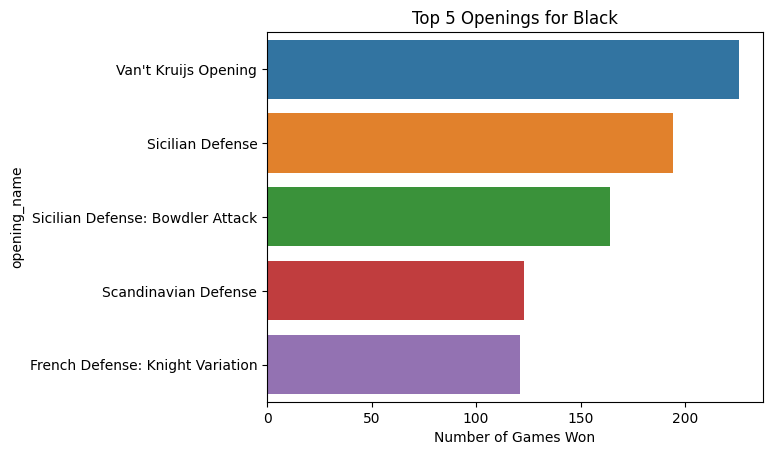

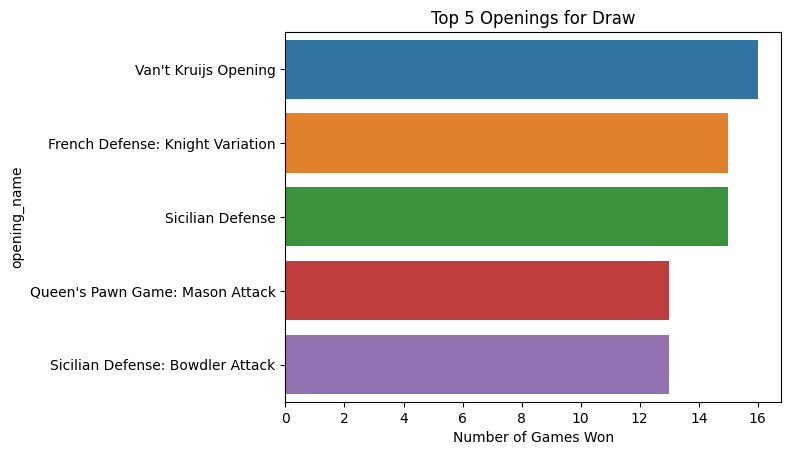

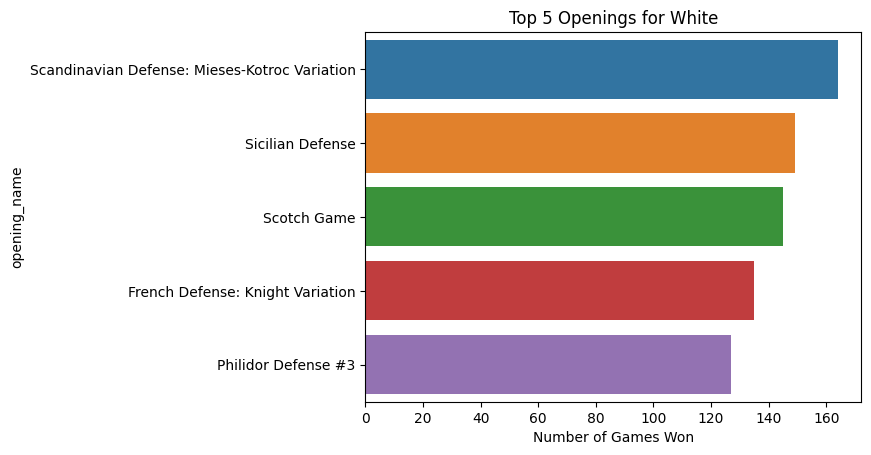

In [3]:
# group the data by the winner column and the opening name column, and count the occurrences
counts = df.groupby(['winner', 'opening_name'])['id'].count()

# extract the top 5 opening names for each winner variation
top_openings = {}
for winner in counts.index.levels[0]:
    top_openings[winner] = counts[winner].sort_values(ascending=False).head(5)

# create a bar chart for each winner variation and its top 10 openings
for winner, openings in top_openings.items():
    plt.figure()
    plt.title(f"Top 5 Openings for {winner.capitalize()}")
    sns.barplot(x=openings.values, y=openings.index, orient='h')
    plt.xlabel("Number of Games Won")
    plt.show()

I then want to see what are the openings with highest win % for both white and black pieces. \
To do that I will select openings that were played at least 100 times, so each opening saw a fair amount of play.

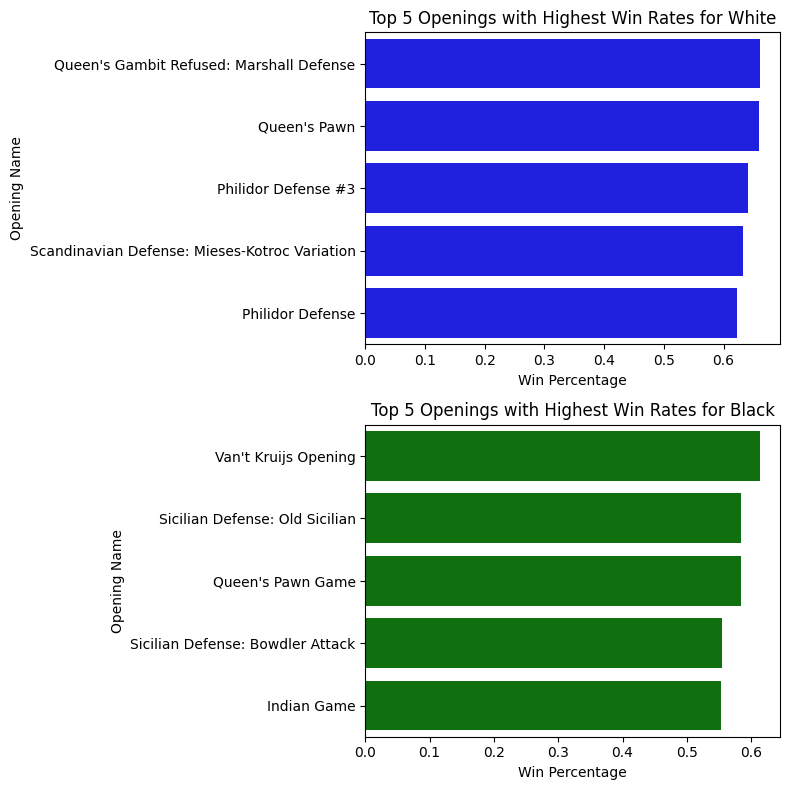

In [14]:
# pivot the data to count the number of games won by each winner for each opening
pivot_table = df.pivot_table(index='opening_name', columns='winner', values='id', aggfunc='count', fill_value=0)

# calculate the total number of wins for each opening
pivot_table['total_wins'] = pivot_table.sum(axis=1)

# filter out the openings that have been used less than 100 times
pivot_table = pivot_table.loc[pivot_table['total_wins'] >= 100]

# calculate the percentage of wins for each winner type for each opening
for winner in ['white', 'black', 'draw']:
    pivot_table[f'{winner}_win_pct'] = pivot_table[winner] / pivot_table['total_wins']

# calculate the total win percentage for each opening
pivot_table['total_win_pct'] = pivot_table['white_win_pct'] + pivot_table['black_win_pct']

# get the top 5 openings with the highest win rates for white and black
top_white_openings = pivot_table.nlargest(5, 'white_win_pct')[['white_win_pct']]
top_black_openings = pivot_table.nlargest(5, 'black_win_pct')[['black_win_pct']]

# plot the bar graphs for the top openings with the highest win rates for white and black
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(8, 8))

sns.barplot(x='white_win_pct', y=top_white_openings.index, data=top_white_openings, color='blue', ax=axes[0])
axes[0].set_xlabel('Win Percentage')
axes[0].set_ylabel('Opening Name')
axes[0].set_title('Top 5 Openings with Highest Win Rates for White')

sns.barplot(x='black_win_pct', y=top_black_openings.index, data=top_black_openings, color='green', ax=axes[1])
axes[1].set_xlabel('Win Percentage')
axes[1].set_ylabel('Opening Name')
axes[1].set_title('Top 5 Openings with Highest Win Rates for Black')

plt.tight_layout()
plt.show()

In [13]:
# Winning percentage of the openings
top_white_openings['white_win_pct'] = (top_white_openings['white_win_pct'] * 100).round(2).astype(str) + '%'
top_black_openings['white_win_pct'] = (top_black_openings['white_win_pct'] * 100).round(2).astype(str) + '%'

print(top_white_openings)
print()
print(top_black_openings)

winner                                        white_win_pct
opening_name                                               
Queen's Gambit Refused: Marshall Defense             66.14%
Queen's Pawn                                         65.89%
Philidor Defense #3                                  64.14%
Scandinavian Defense: Mieses-Kotroc Variation        63.32%
Philidor Defense                                     62.22%

winner                            black_win_pct
opening_name                                   
Van't Kruijs Opening                   0.614130
Sicilian Defense: Old Sicilian         0.584906
Queen's Pawn Game                      0.584507
Sicilian Defense: Bowdler Attack       0.554054
Indian Game                            0.552486


## Players ratings

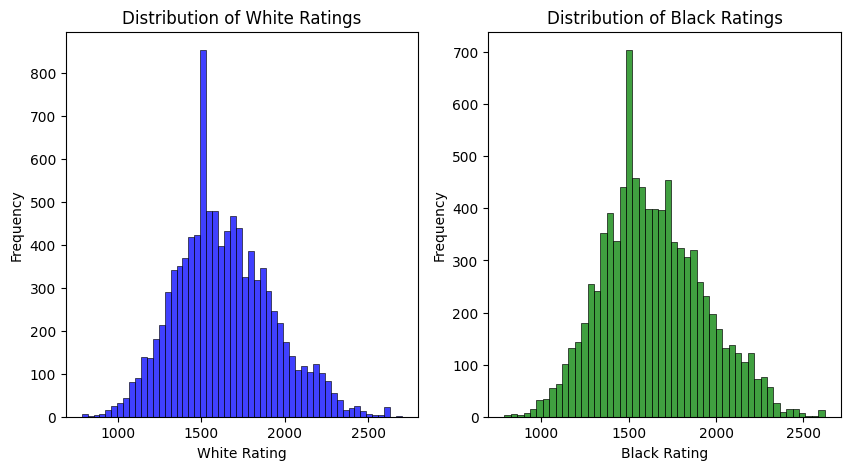

In [16]:
# Creating a new column with the outcome of the game (win/loss/draw)
df['outcome'] = df['winner'].apply(lambda x: 'draw' if x == 'draw' else 'win' if x == 'white' else 'loss')

import matplotlib.pyplot as plt

# Create subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

# Plot the first graph
sns.histplot(df[df['winner']=='white']['white_rating'], ax=ax1, color='blue')
ax1.set_xlabel('White Rating')
ax1.set_ylabel('Frequency')
ax1.set_title('Distribution of White Ratings')

# Plot the second graph
sns.histplot(df[df['winner']=='black']['black_rating'], ax=ax2, color='green')
ax2.set_xlabel('Black Rating')
ax2.set_ylabel('Frequency')
ax2.set_title('Distribution of Black Ratings')

# Display the plot
plt.show()

<AxesSubplot:xlabel='winner', ylabel='rating_diff'>

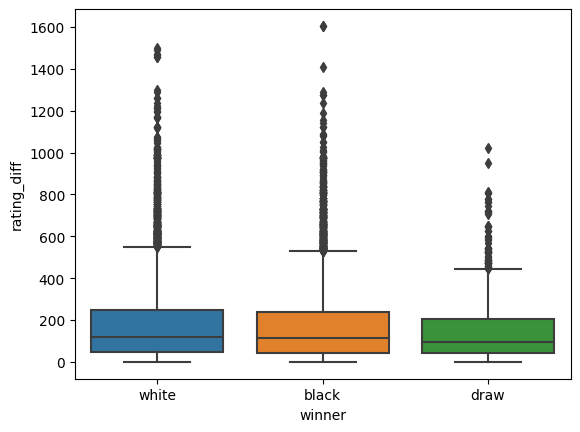

In [17]:
# Calculate the average rating difference
df['rating_diff'] = abs(df['white_rating'] - df['black_rating'])

# Analyze the relationship between rating difference and game outcomes
sns.boxplot(x='winner', y='rating_diff', data=df)

This shows that players that are closer in rating have a higher chance to draw, when players have a relatively high difference in rating the game tends to have a winner, we can see the result in higher details below

<AxesSubplot:xlabel='rating_diff'>

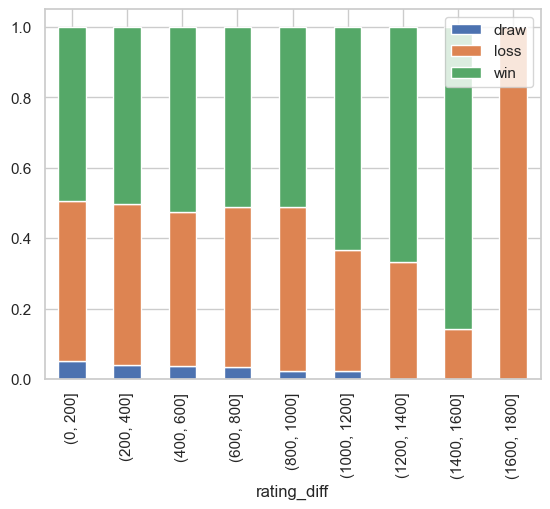

In [22]:
# Calculate the average rating difference for each game
df["rating_diff"] = abs(df["white_rating"] - df["black_rating"])

# Create a column indicating the game outcome (win/loss/draw)
df["outcome"] = df["winner"].apply(lambda x: "draw" if x == "draw" else "win" if x == "white" else "loss")

# Calculate the win rate for each rating difference group
win_rates = df.groupby(pd.cut(df["rating_diff"], bins=[0, 200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000, 2200, 2400, 2600, 2800, 3000])).apply(lambda x: x["outcome"].value_counts(normalize=True)).unstack()

# Plot the win rates
sns.set(style="whitegrid")
win_rates.plot(kind="bar", stacked=True)


## Game Lenght

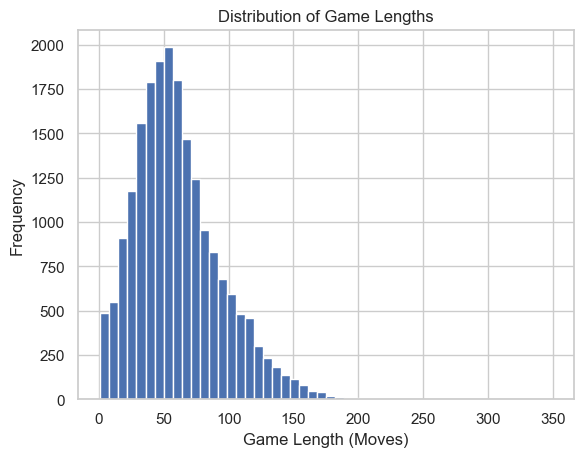

In [23]:

# Create a new column for game length in moves
df['game_length'] = df['turns']

# Plot the distribution of game lengths
plt.hist(df['game_length'], bins=50)
plt.xlabel('Game Length (Moves)')
plt.ylabel('Frequency')
plt.title('Distribution of Game Lengths')
plt.show()

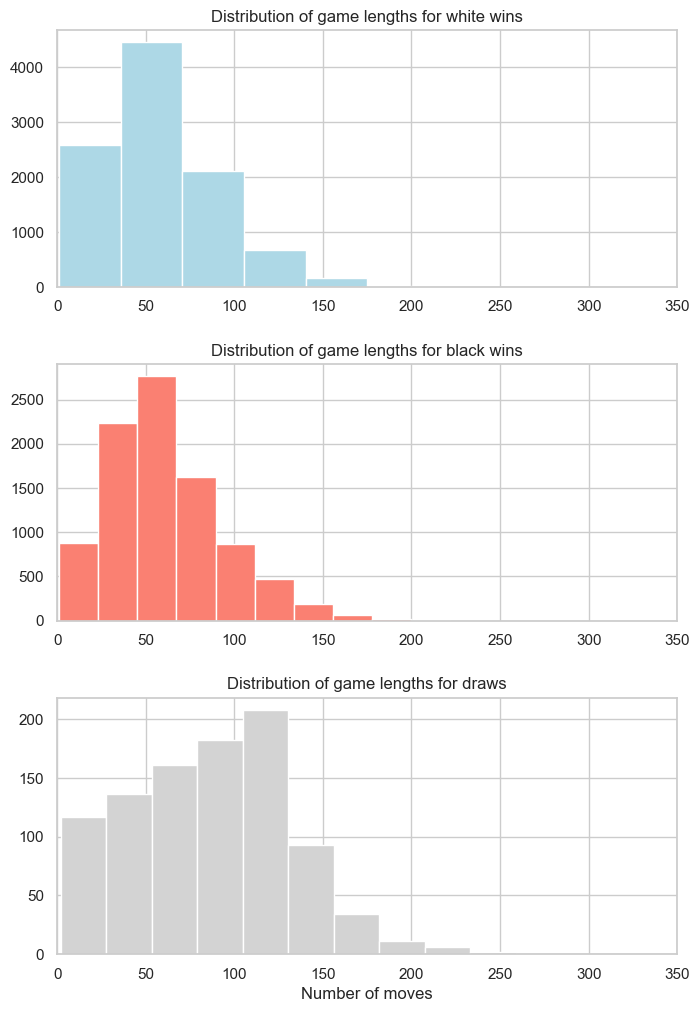

In [29]:
# Add a column for game length in moves
df['game_length_moves'] = df['moves'].str.split().apply(len)

# Plot the distribution of game lengths for each outcome
fig, ax = plt.subplots(3, 1, figsize=(8, 12))
df[df['winner'] == 'white'].hist('game_length_moves', ax=ax[0], color='lightblue')
df[df['winner'] == 'black'].hist('game_length_moves', ax=ax[1], color='salmon')
df[df['winner'] == 'draw'].hist('game_length_moves', ax=ax[2], color='lightgray')

# Set the same x-axis limit for all subplots
for a in ax:
    a.set_xlim([0, 350])

# Add titles and labels
ax[0].set_title('Distribution of game lengths for white wins')
ax[1].set_title('Distribution of game lengths for black wins')
ax[2].set_title('Distribution of game lengths for draws')
ax[2].set_xlabel('Number of moves')
plt.show()

As we can see drawn games tend to go for longer.

## Victory

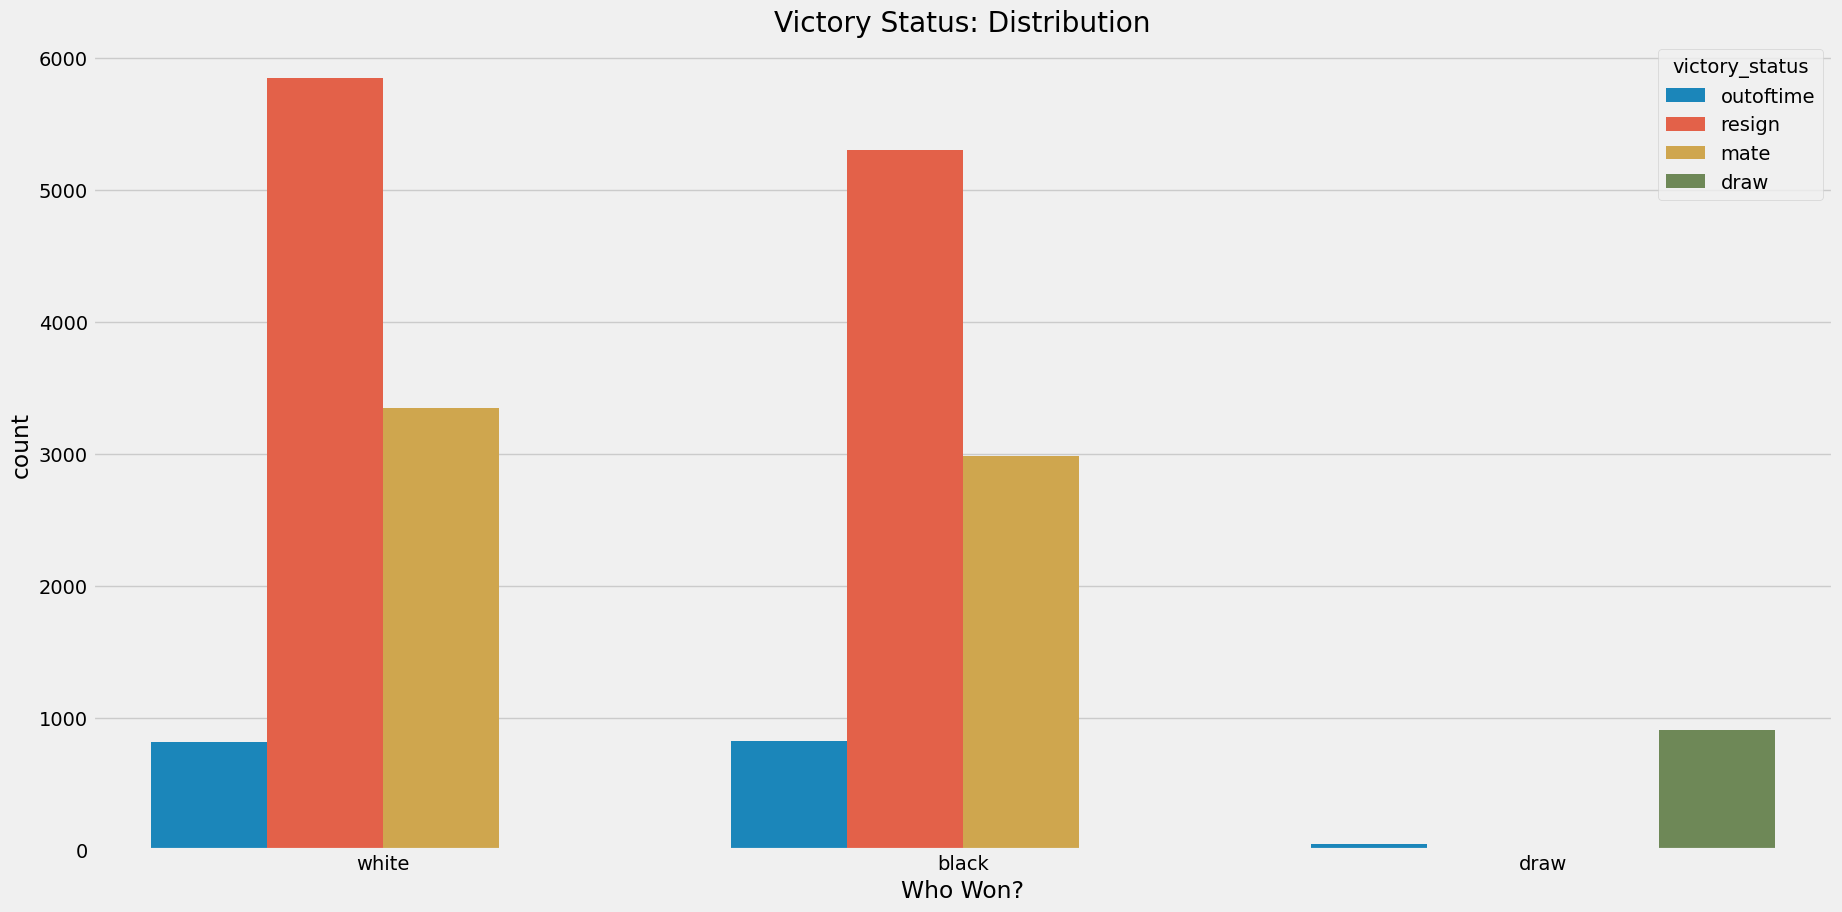

In [ ]:
#games['victory_status'].value_counts().plot.bar()
ax = sns.countplot( x = 'winner', hue = 'victory_status', data = df)
ax_attr = ax.set(xlabel = 'Who Won?', title = 'Victory Status: Distribution')

Resignation seems to be the most common form of victory for both black and white. \
Regarding a draw, there are a couple ways that a game could end in a draw
- When both players agree to Draw
- When a player has made the same moves, or is about to make the same move, three times in a row
- If both players haven’t made any progress in fifty moves
- If neither player has enough pieces left on the board so that they can Check-Mate the other player \
\
The case of a draw because of "outoftime" happens when player A runs out of time but player B does not have enough material to check-mate his opponent